In [145]:
import sys
import os
from osgeo import gdal,osr,ogr
import numpy as np
sys.path.append("..")
from knool.image import img_proc
import matplotlib.pyplot as plt

(1000, 2000, 1)


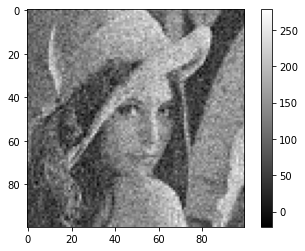

In [224]:
raster=gdal.Open(r"../../test_data/test.png")
true_array=raster.ReadAsArray()[0]/2+255/1.8
offset_x=350
offset_y=200
true_array=np.pad(true_array, pad_width=((offset_x, offset_x), (offset_y, offset_y)), mode="edge")#mode='symmetric')
offset=500
img0=np.pad(true_array, pad_width=((offset, offset), (offset, offset)), mode="edge")#mode='symmetric')
img=img0[1000:2000,4000:6000].reshape(1000,2000,1)
img2=img0[1003:2003,4004:6004].reshape(1000,2000,1)
print(img.shape)
plt.imshow(img,cmap="gray")

raster=gdal.Open(r"../../test_data/lena.jpg")
true_array=raster.ReadAsArray()

sigma=20
img=true_array[20:120,20:120].reshape(100,100,1)
img=np.random.normal(img, sigma, img.shape) 
img2=true_array[27:127,26:126].reshape(100,100,1)
img2=np.random.normal(img2, sigma, img2.shape)

plt.imshow(img,cmap="gray")
plt.colorbar()

In [259]:
ix=np.random.randint(10,90,1000)
iy=np.random.randint(10,90,1000)

sim,dy,dx=img_proc.calc_offset(img,img2,iy,ix,sim_type=int(2),nsw=int(15))
#print(sim)
print(np.std(dx+7))
print(np.std(dy+6))

print(np.mean(np.abs(dx+7)))
print(np.mean(np.abs(dy+6)))


1.4082582
1.2496043
0.447
0.349
 nx=         100 ny=         100 band=           1 nz=        1000


In [ ]:
scene_offset_x=[0,5000,0,5000]
scene_offset_y=[0,0,5000,5000]
motion_per_swath=1000
plt.figure(figsize=(16,8))
range_x=int(18000/100)
range_y=int(18000/100)
cols=np.arange(-range_x,range_x+1)
rows=np.arange(-range_y,range_y+1)
index_i,index_j = np.meshgrid(cols, rows)
index_ij=np.array([[index_i.reshape(-1),index_j.reshape(-1)]]).astype(np.int32)

ap_sum=np.nansum(ap2)

grid_x_list=[]
grid_y_list=[]
obs_list=[]
for i in range(1):
    distance=i*motion_per_swath
    dist_xy=distance/np.sqrt(2)/100
    print("motion value=",distance,dist_xy)

    index_amsr0=np.array([(x_amsr+scene_offset_x[i])/100,(y_amsr+scene_offset_y[i])/100])    
    grid_x=index_amsr0[0]
    grid_y=index_amsr0[1]
    index_amsr=np.round(index_amsr0+offset+dist_xy)
    index_amsr=index_amsr.astype(np.int32)+index_ij.T    
    index_amsr=index_amsr.transpose(2,0,1)
    n_point,n_kernel,_=index_amsr.shape
    index_amsr=index_amsr.reshape(n_point*n_kernel,2)
    obs=np.nansum(img[index_amsr[:,1],index_amsr[:,0]].reshape(n_point,n_kernel)*ap2,axis=1)/ap_sum #/np.nansum(ap2)

#    print(obs.shape,index_amsr.shape)
    grid_x_list.append(grid_x)
    grid_y_list.append(grid_y)
    obs_list.append(obs)
    
grid_x=np.concatenate(grid_x_list,axis=0)
grid_y=np.concatenate(grid_y_list,axis=0)
obs=np.concatenate(obs_list,axis=0)
print(grid_x.shape,obs.shape)
del(index_amsr)


motion value= 0 0.0


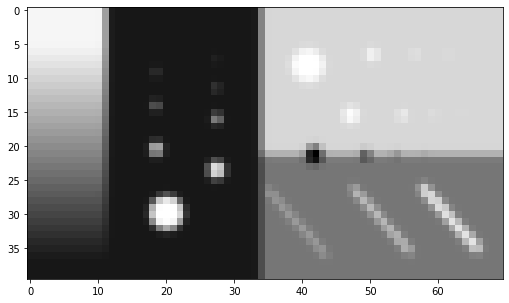

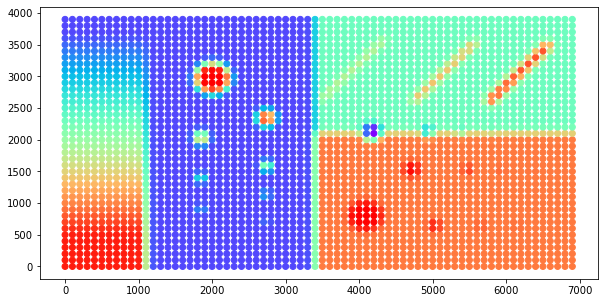

In [142]:
plt.figure(figsize=(10,5))
plt.imshow(obs.reshape([40,70]),cmap="gray")
plt.show()
plt.figure(figsize=(10,5))
plt.scatter(grid_x,grid_y,c=obs,cmap="rainbow")


0.0 6900.0 3900.0 (2800,)
1.0 139.0 79.0
(2800,)
1.0 139.0
1.0 79.0
149.69254726543443 269.16666627294876
(2800,) (2800,) (2800,)
140 80


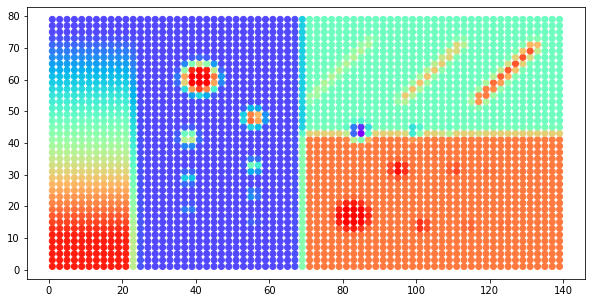

In [184]:
res=float(5000)
fwhm=float(15000)
wsize=int(31)

grid_x2=grid_x*100/res+1
grid_y2=grid_y*100/res+1
print(np.min(grid_x),np.max(grid_x),np.max(grid_y),grid_x.shape)
print(np.min(grid_x2),np.max(grid_x2),np.max(grid_y2))
width=int(7000*100/res)
height=int(4000*100/res)
mask=np.full([width,height],0)


print(grid_x2.shape)
dum_x2=np.round(grid_x2)
dum_y2=np.round(grid_y2)
index_mask=(dum_x2>0)&(dum_x2<width)&(dum_y2>0)&(dum_y2<height)
grid_x2=grid_x2[index_mask]
grid_y2=grid_y2[index_mask]
obs2=obs[index_mask]
# obs2=obs

print(np.min(grid_x2),np.max(grid_x2))
print(np.min(grid_y2),np.max(grid_y2))
print(np.min(obs2),np.max(obs2))
print(grid_x2.shape,grid_y2.shape,obs2.shape)
plt.figure(figsize=(10,5))
plt.scatter(grid_x2,grid_y2,c=obs2,cmap="rainbow")
print(width,height)


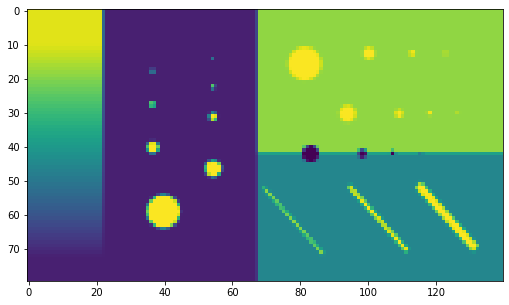

 image nx=         140 ,ny=          80
 antenna pattern nx=         361 ,ny=         361


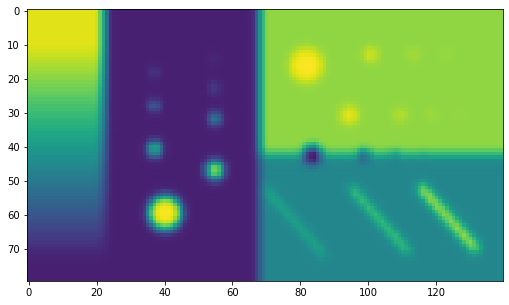

 image nx=         140 ,ny=          80
 antenna pattern nx=         361 ,ny=         361


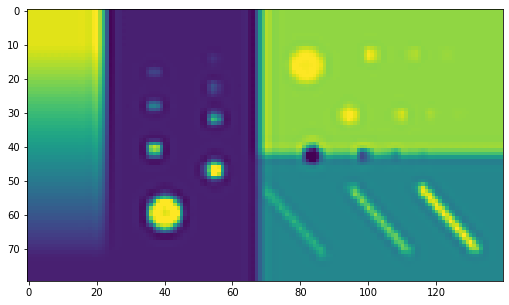

In [185]:

trueimg=img_proc.resize(true_array,height,width)
plt.figure(figsize=(10,5))
plt.imshow(trueimg,vmin=150,vmax=270)
plt.show()
interp=fpmw.test_sir(grid_x2,grid_y2,obs2,mask,wsize,ap3.T,int_ap=float(100.0),res=res,fwhm=fwhm)
interp=np.where(interp>9.9E32,trueimg.T,interp)
plt.figure(figsize=(10,5))
plt.imshow(interp.T,vmin=150,vmax=270)
plt.show()
highres=fpmw.sir(grid_x2,grid_y2,obs2,mask,wsize,ap3.T,int_ap=float(100.0),res=res,fwhm=fwhm,iterate=int(20))
highres=np.where(highres>9.9E32,trueimg.T,highres)
# print(np.max(out_val),np.min(out_val),out_val)
plt.figure(figsize=(10,5))
plt.imshow(highres.T,vmin=150,vmax=270)
plt.show()


(42.43749580585676, 0.0, 0.0, 0.0)


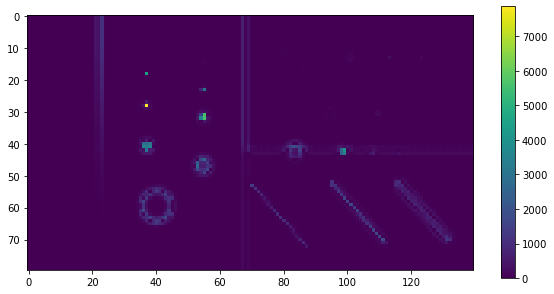

(20.27904677275899, 0.0, 0.0, 0.0)


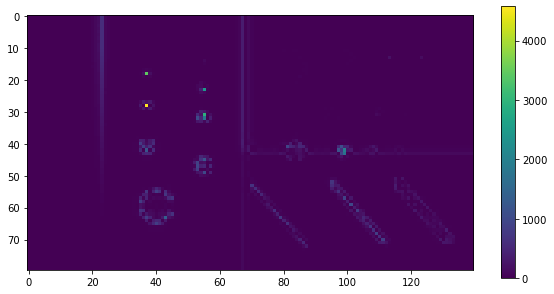

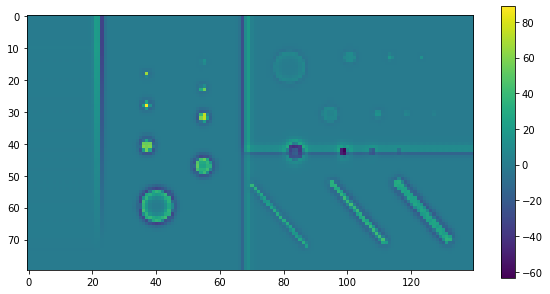

In [186]:
# a,b=get_ssmi(highres,interp)
# a,b=get_snr(highres,interp)

offset_t=int(res/100/2)
true_array2=np.pad(true_array, pad_width=((offset_t, 0), (offset_t, 0)), mode="edge")#mode='symmetric')
trueimg=img_proc.resize(true_array2[:-offset_t,:-offset_t],height,width)
#trueimg=img_proc.resize(true_array,height,width)



a,b=img_stats.get_mse(trueimg.T,interp)
print(a)
plt.figure(figsize=(10,5))
plt.imshow(b.T)
plt.colorbar()
plt.show()
a,b=img_stats.get_mse(trueimg.T,highres)
print(a)
plt.figure(figsize=(10,5))
plt.imshow(b.T)
plt.colorbar()
plt.show()
plt.figure(figsize=(10,5))
plt.imshow(trueimg-interp.T)
plt.colorbar()
plt.show()

# plt.figure(figsize=(10,5))
# plt.imshow(interp.T-obs.reshape([40,70]))
# plt.colorbar()
# plt.show()




# print(img_stats.get_vifp_mscale(trueimg.T,interp))
# print(img_stats.get_vifp_mscale(trueimg.T,highres))


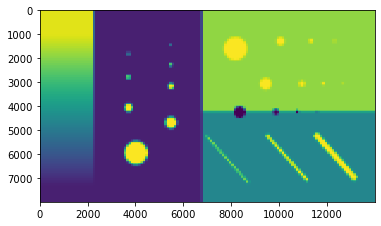

ValueError: operands could not be broadcast together with shapes (8000,14000) (4000,7000) 

In [170]:
trueimg=img_proc.resize(true_array,height,width).repeat(100,axis=0).repeat(100,axis=1)
# plt.figure(figsize=(10,5))
plt.imshow(trueimg,vmin=150,vmax=270)
plt.show()
plt.imshow(trueimg-true_array)
print(true_array.shape,height,width,true_array.dtype)

In [102]:
test=np.array([np.arange(0,10,1)]).astype(np.float64)
test=test.repeat(10,axis=0)
print(test.shape,test.dtype)
print(test)
test=img_proc.resize(test,5,5)
print(test)

(10, 10) float64
[[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
 [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
 [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
 [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
 [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
 [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
 [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
 [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
 [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
 [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]]
[[0.5 2.5 4.5 6.5 8.5]
 [0.5 2.5 4.5 6.5 8.5]
 [0.5 2.5 4.5 6.5 8.5]
 [0.5 2.5 4.5 6.5 8.5]
 [0.5 2.5 4.5 6.5 8.5]]
